In [2]:
PROJECT_TITLE = "Comparing Classifiers on UCI Bank Marketing"
AUTHOR = "Luke"
RANDOM_STATE = 42
print(PROJECT_TITLE, "| Author:", AUTHOR)

import os, io, zipfile, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    classification_report
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC


Comparing Classifiers on UCI Bank Marketing | Author: Luke


In [3]:
print(textwrap.dedent("""
Business Question
-----------------
Which customers are most likely to subscribe to a term deposit after a telemarketing call?
We will compare several classifiers and recommend a simple, reliable model the bank can use.
"""))



Business Question
-----------------
Which customers are most likely to subscribe to a term deposit after a telemarketing call?
We will compare several classifiers and recommend a simple, reliable model the bank can use.



In [4]:
CANDIDATE_PATHS = [
    "data/bank-additional/bank-additional-full.csv",
    "data/bank-additional-full.csv",
    "data/bank.csv",
    "bank-additional-full.csv",
    "bank.csv",
    "bank+marketing.zip",          
    "data/bank+marketing.zip",
]

def load_bank_dataframe(paths):
    for p in paths:
        if not os.path.exists(p): 
            continue
        if p.endswith(".zip"):
            with zipfile.ZipFile(p, "r") as zf:
                # try common member names
                for member in zf.namelist():
                    if member.endswith(".csv"):
                        with zf.open(member) as f:
                            try:
                                df = pd.read_csv(f, sep=";")
                            except Exception:
                                f.seek(0)
                                df = pd.read_csv(f)  # fallback
                        print(f"Loaded from ZIP member: {member}")
                        return df
        else:
            try:
                df = pd.read_csv(p, sep=";")
            except Exception:
                df = pd.read_csv(p)
            print(f"Loaded: {p}")
            return df
    raise FileNotFoundError("Could not find the dataset. Please set CANDIDATE_PATHS to your CSV/ZIP.")

df = load_bank_dataframe(CANDIDATE_PATHS)
df.head()


Loaded: bank.csv


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
print(df.shape)
df.info()
df['y'].value_counts(normalize=True).rename('class balance')


(4521, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


y
no     0.88476
yes    0.11524
Name: class balance, dtype: float64

In [6]:
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

df['target'] = (df['y'].str.lower() == 'yes').astype(int)
df.drop(columns=['y'], inplace=True)

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

num_cols, cat_cols[:8]  


(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month'])

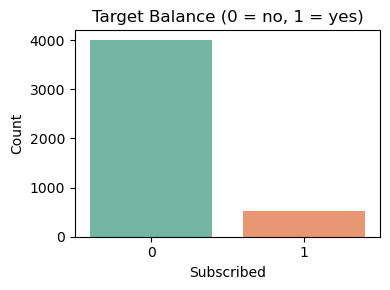

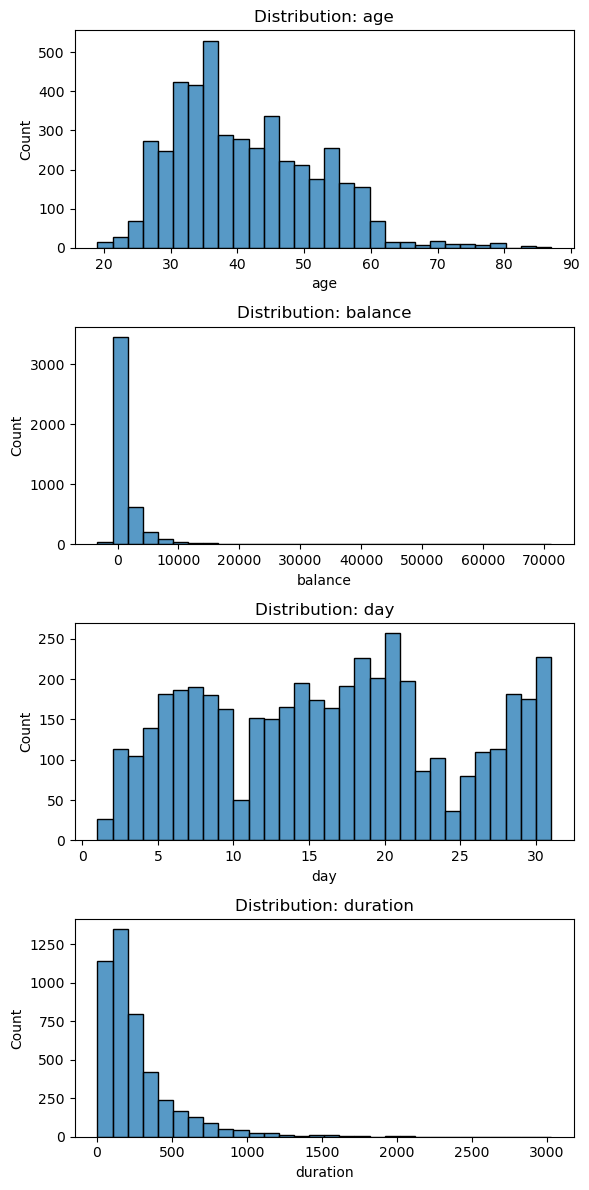

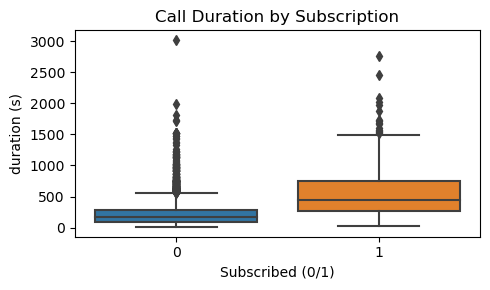

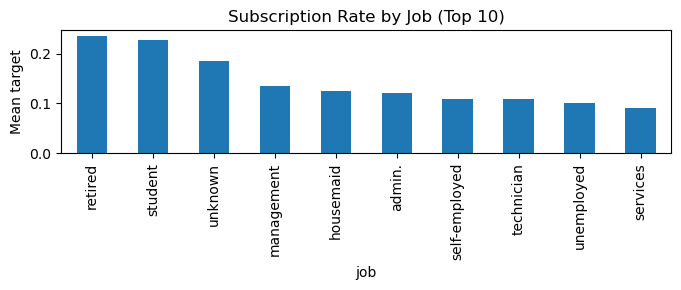

In [7]:
plt.figure(figsize=(4,3))
ax = sns.countplot(x=y, palette="Set2")
ax.set_title("Target Balance (0 = no, 1 = yes)")
ax.set_xlabel("Subscribed")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=min(4, len(num_cols)), ncols=1, figsize=(6, 3*min(4, len(num_cols))))
if not isinstance(axes, np.ndarray): axes = [axes]
for ax, col in zip(axes, num_cols[:4]):
    sns.histplot(df[col], bins=30, ax=ax)
    ax.set_title(f"Distribution: {col}")
    ax.set_xlabel(col); ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

if 'duration' in df.columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(data=df, x='target', y='duration')
    plt.title("Call Duration by Subscription")
    plt.xlabel("Subscribed (0/1)"); plt.ylabel("duration (s)")
    plt.tight_layout(); plt.show()

if 'job' in df.columns:
    job_rate = df.groupby('job')['target'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(7,3))
    job_rate.plot(kind='bar')
    plt.title("Subscription Rate by Job (Top 10)")
    plt.ylabel("Mean target"); plt.xlabel("job")
    plt.tight_layout(); plt.show()


In [8]:
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def summarize_results(name, grid):
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        y_proba = best.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        if hasattr(best, "decision_function"):
            scores = best.decision_function(X_test)
            auc = roc_auc_score(y_test, scores)
        else:
            auc = np.nan

    res = {
        "model": name,
        "best_params": grid.best_params_,
        "acc": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": auc
    }
    return res, y_pred, best


In [10]:
results = []
fitted = {}   

knn = Pipeline([("prep", preprocess),
                ("clf", KNeighborsClassifier())])
knn_param = {"clf__n_neighbors": [5, 15, 31],
             "clf__weights": ["uniform", "distance"]}
knn_gs = GridSearchCV(knn, knn_param, cv=cv, n_jobs=-1, scoring="f1")
knn_gs.fit(X_train, y_train)
res, y_pred, best = summarize_results("KNN", knn_gs)
results.append(res); fitted["KNN"] = best

logit = Pipeline([("prep", preprocess),
                  ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=RANDOM_STATE))])
logit_param = {"clf__C": [0.1, 1.0, 10.0]}
logit_gs = GridSearchCV(logit, logit_param, cv=cv, n_jobs=-1, scoring="f1")
logit_gs.fit(X_train, y_train)
res, y_pred, best = summarize_results("LogisticRegression", logit_gs)
results.append(res); fitted["LogisticRegression"] = best

dt = Pipeline([("prep", preprocess),
               ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))])
dt_param = {"clf__max_depth": [None, 6, 12],
            "clf__min_samples_leaf": [1, 5, 10]}
dt_gs = GridSearchCV(dt, dt_param, cv=cv, n_jobs=-1, scoring="f1")
dt_gs.fit(X_train, y_train)
res, y_pred, best = summarize_results("DecisionTree", dt_gs)
results.append(res); fitted["DecisionTree"] = best

lsvc = Pipeline([("prep", preprocess),
                 ("clf", LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))])
lsvc_param = {"clf__C": [0.5, 1.0, 2.0]}
lsvc_gs = GridSearchCV(lsvc, lsvc_param, cv=cv, n_jobs=-1, scoring="f1")
lsvc_gs.fit(X_train, y_train)
res, y_pred, best = summarize_results("LinearSVC", lsvc_gs)
results.append(res); fitted["LinearSVC"] = best

svc = Pipeline([("prep", preprocess),
                ("clf", SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE))])
svc_param = {"clf__C": [1.0, 3.0], "clf__gamma": ["scale", 0.1]}
svc_gs = GridSearchCV(svc, svc_param, cv=cv, n_jobs=-1, scoring="f1")
svc_gs.fit(X_train, y_train)
res, y_pred, best = summarize_results("SVC_RBF", svc_gs)
results.append(res); fitted["SVC_RBF"] = best

pd.DataFrame(results).sort_values("f1", ascending=False)


  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/conda/envs/anac

,model,best_params,acc,precision,recall,f1,roc_auc
4,SVC_RBF,"{'clf__C': 1.0, 'clf__gamma': 0.1}",0.846409,0.409326,0.759615,0.531987,0.898240
3,LinearSVC,{'clf__C': 1.0},0.826519,0.375587,0.769231,0.504732,0.890461
1,LogisticRegression,{'clf__C': 0.1},0.822099,0.371041,0.788462,0.504615,0.891578
2,DecisionTree,"{'clf__max_depth': 12, 'clf__min_samples_leaf'...",0.786740,0.321285,0.769231,0.453258,0.791907
0,KNN,"{'clf__n_neighbors': 5, 'clf__weights': 'unifo...",0.883978,0.487179,0.182692,0.265734,0.769219


Best model by F1: SVC_RBF 
Best params: {'clf__C': 1.0, 'clf__gamma': 0.1}


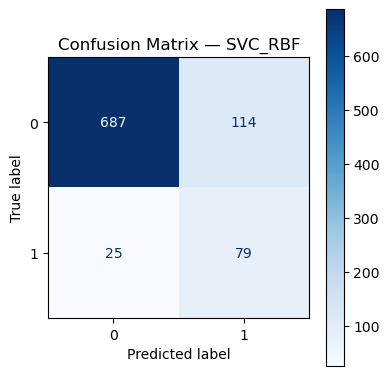

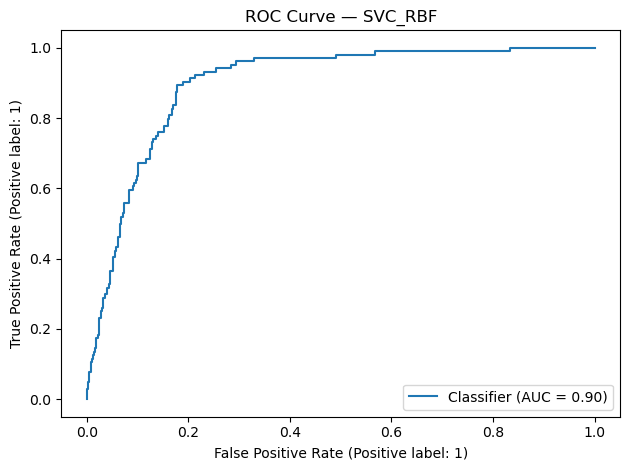

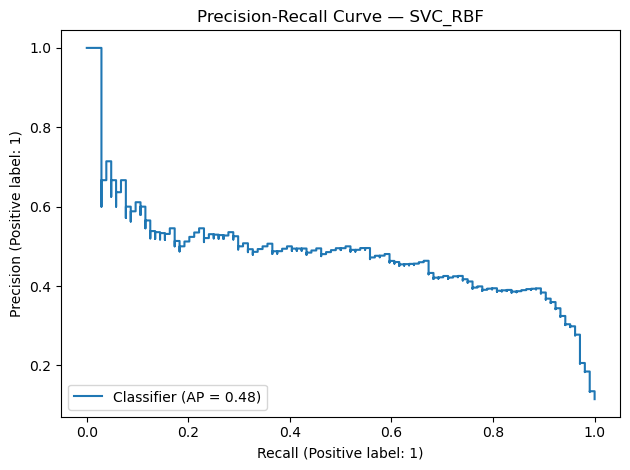

              precision    recall  f1-score   support

           0     0.9649    0.8577    0.9081       801
           1     0.4093    0.7596    0.5320       104

    accuracy                         0.8464       905
   macro avg     0.6871    0.8086    0.7201       905
weighted avg     0.9010    0.8464    0.8649       905



In [11]:
res_df = pd.DataFrame(results).sort_values("f1", ascending=False)
best_name = res_df.iloc[0]["model"]
best_est = fitted[best_name]
print("Best model by F1:", best_name, "\nBest params:", [r for r in results if r["model"]==best_name][0]["best_params"])

y_pred = best_est.predict(X_test)
if hasattr(best_est, "predict_proba"):
    y_proba = best_est.predict_proba(X_test)[:,1]
elif hasattr(best_est, "decision_function"):
    y_proba = best_est.decision_function(X_test)
else:
    y_proba = None

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues")
ax.set_title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()

if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {best_name}")
    plt.tight_layout(); plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Precision-Recall Curve — {best_name}")
    plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred, digits=4))


In [12]:
logit_best = fitted.get("LogisticRegression")
if logit_best is not None:
    ohe = logit_best.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
    cat_features = ohe.get_feature_names_out(cat_cols)
    feature_names = np.r_[num_cols, cat_features]
    coefs = pd.Series(logit_best.named_steps["clf"].coef_.ravel(), index=feature_names).sort_values()
    print("Logistic Regression: Top 10 negative features (lower subscription odds):")
    display(coefs.head(10))
    print("Logistic Regression: Top 10 positive features (higher subscription odds):")
    display(coefs.tail(10))


Logistic Regression: Top 10 negative features (lower subscription odds):


poutcome_unknown   -0.762607
month_jan          -0.736450
month_may          -0.720572
contact_unknown    -0.687566
month_jul          -0.594583
month_nov          -0.556449
poutcome_failure   -0.490227
loan_yes           -0.425961
job_blue-collar    -0.366758
campaign           -0.364373
dtype: float64

Logistic Regression: Top 10 positive features (higher subscription odds):


contact_telephone    0.331400
contact_cellular     0.335438
month_sep            0.370371
loan_no              0.405233
job_student          0.453102
job_retired          0.492872
month_mar            0.995028
month_oct            1.197316
poutcome_success     1.215245
duration             1.425880
dtype: float64

In [13]:
print(textwrap.dedent(f"""
Findings & Recommendations
--------------------------
• Best performing model (by F1): {best_name}.
• Overall, F1 and ROC–AUC indicate the classifier captures the minority 'subscribe' class better than
  a naive baseline. Accuracy alone can be misleading due to class imbalance.

Business Takeaways
• Longer call duration and certain campaign/previous outcome indicators are associated with higher subscription odds.
• Certain categories (e.g., job, poutcome, month) shift conversion rates meaningfully.

Next Steps
• Calibrate the chosen model (e.g., Platt scaling) and choose an operating threshold that balances precision/recall for the call center.
• Try simple cost-sensitive tuning (class weights or threshold) to reduce false positives/negatives depending on business costs.
• Consider feature selection or monotonic GBMs if stakeholders want stronger interpretability.
""")))


SyntaxError: unmatched ')' (1963649230.py, line 16)